#### Classification

In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

##### Custom Import

In [23]:
from rfd.EvaluateModel import evaluate_model

## Feature Extraction 
- Train Test Split
- Vectorization TF-IDF Vectorization

In [3]:
df = pd.read_csv("dataframes/df_processed.csv", usecols=['text', 'link_flair_text']).sample(frac=0.25) ## reading only 25% of data

In [5]:
le = LabelEncoder()
le.fit(df.link_flair_text)

LabelEncoder()

In [6]:
df['label'] = le.transform(df.link_flair_text)

### Vectorization 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
vectorizer = TfidfVectorizer(analyzer = "word", max_features=10000)
data = vectorizer.fit_transform(df['text'])

### train set split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.15)

In [12]:
## samples
print(f'Samples in train set = {X_train.shape[0]}\nSamples in test set = {X_test.shape[0]}')

Samples in train set = 21292
Samples in test set = 3758


In [13]:
X_ = X_train.toarray()
x_ = X_test.toarray()

#### Scaling

In [14]:
## Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# X_norm = scaler.fit(X_)

In [15]:
X_norm = scaler.fit_transform(X_)

In [16]:
X_test_norm = scaler.transform(x_)

#### Feature Selection

In [17]:
from sklearn.feature_selection import SelectFromModel

In [18]:
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_norm, y_train)
fs = SelectFromModel(lsvc, prefit=True)
X_selected = fs.transform(X_norm)
X_test_selected = fs.transform(X_test_norm)

In [19]:
from IPython.display import Markdown, display
def show_top10_features(classifier, feature_names, categories):
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))

In [22]:
feature_names = np.array(vectorizer.get_feature_names())
show_top10_features(lsvc, feature_names, le.inverse_transform(lsvc.classes_))

**AskIndia**: handsome, recommendation, flying, viable, companion, scrutiny, sync, cv, sensor, passbook

**Business/Finance**: lo, go, tool, bulk, ccd, repercussion, counselor, subsidiary, grotal, promoter

**Coronavirus**: casualty, donate, ramp, remix, end, immunity, deceased, aside, ppe, sanitize

**Food**: roadside, benefit, finger, dish, confusing, miss, vegan, recipe, fry, tasty

**Non-Political**: explicitly, fracture, confess, countrywide, queue, bohot, playstore, muh, seasonal, rp

**Photography**: library, jewellery, acting, hint, morning, terminal, ancestor, orissa, head, photography

**Policy/Economy**: deterrent, ayushman, exclusion, ownership, ist, complicate, iff, nizamuddin, drastically, unpaid

**Politics**: arabs, rakha, entail, closer, arrogance, proportional, rajnath, churn, jibe, amu

**Science/Technology**: invisible, affair, deficiency, americas, landline, mlm, movies, gadgetbridge, install, beware

**Sports**: nike, dhoni, plumber, tournament, karo, chess, chand, sports, ipl, olympics

**[R]eddiquette**: void, unheard, summarize, subah, arre, fck, exciting, pyramid, crony, colour

#### Inference: In the above print we can see that top features are related the to the correspponding Flairs

## Text Classificaiton with sklearn models 

### 1. Multinomial NB

In [25]:
mb = MultinomialNB()
mb.fit(X_selected, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy test: 0.47 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.47      0.57      0.52       668
  Business/Finance       0.74      0.38      0.50       237
       Coronavirus       0.63      0.53      0.58       203
              Food       0.82      0.20      0.33        44
     Non-Political       0.44      0.50      0.47       928
       Photography       0.59      0.27      0.37        86
    Policy/Economy       0.43      0.31      0.36       160
          Politics       0.65      0.81      0.72      1084
Science/Technology       0.56      0.22      0.31       175
            Sports       0.78      0.40      0.53        52
     [R]eddiquette       0.38      0.04      0.07       121

          accuracy                           0.55      3758
         macro avg       0.59      0.38      0.43      3758
      weighted avg       0.55      0.55      0.53      3758

Test confusion matrix: 


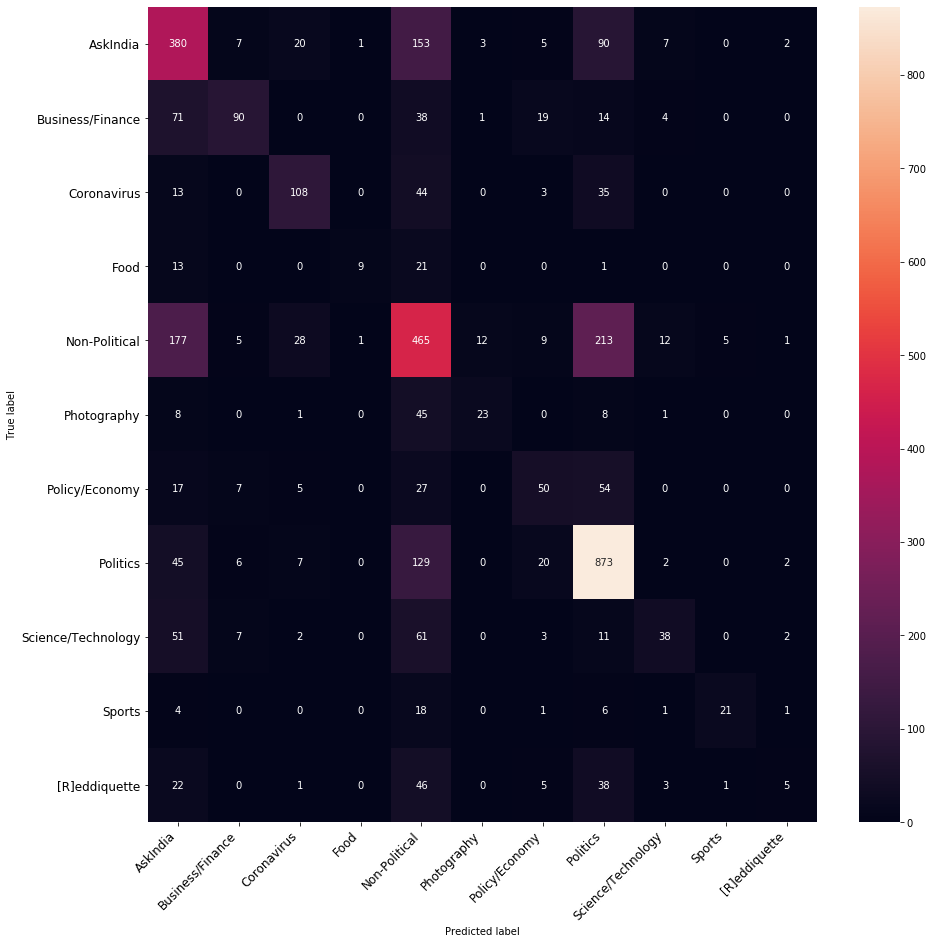

In [27]:
evaluate_model(mb, X_test_selected, y_test, target_names=le.classes_)

### 2. ComplementNaiveBayes Model

Accuracy test: 0.49 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.46      0.58      0.51       668
  Business/Finance       0.62      0.46      0.53       237
       Coronavirus       0.55      0.67      0.60       203
              Food       0.40      0.39      0.39        44
     Non-Political       0.52      0.35      0.42       928
       Photography       0.43      0.43      0.43        86
    Policy/Economy       0.37      0.34      0.35       160
          Politics       0.65      0.82      0.72      1084
Science/Technology       0.45      0.30      0.36       175
            Sports       0.60      0.63      0.62        52
     [R]eddiquette       0.34      0.08      0.13       121

          accuracy                           0.55      3758
         macro avg       0.49      0.46      0.46      3758
      weighted avg       0.53      0.55      0.53      3758

Test confusion matrix: 


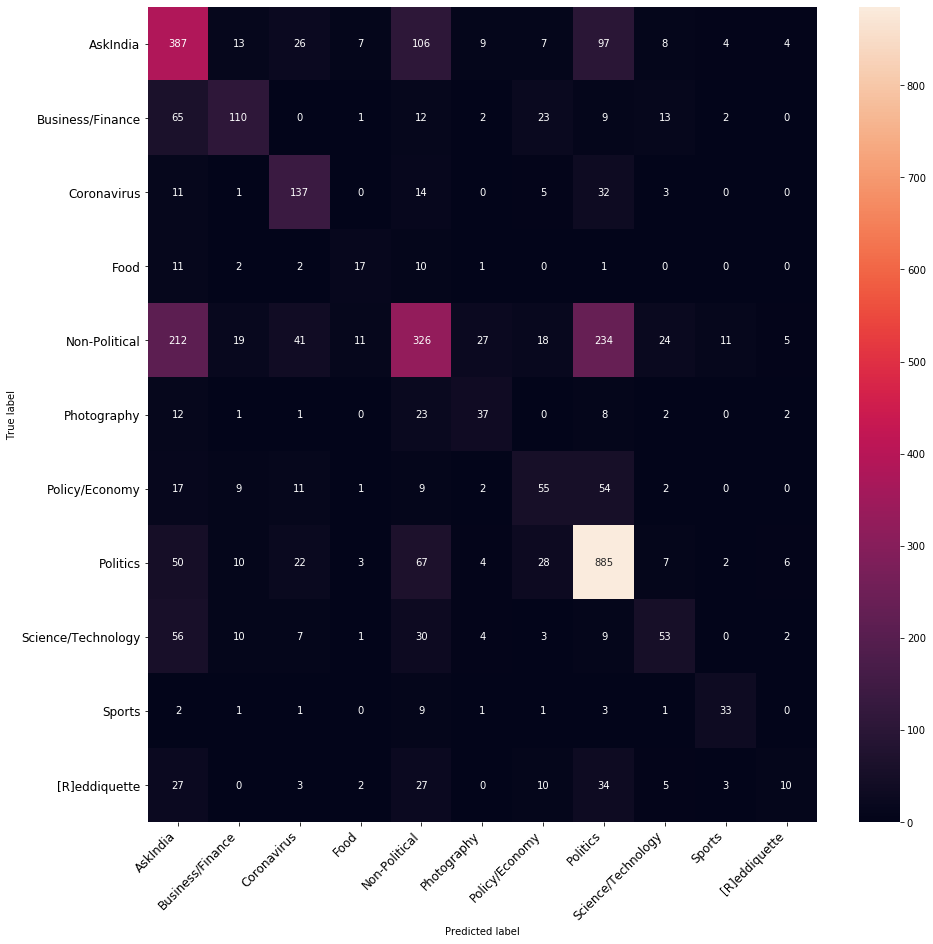

In [29]:
cb = ComplementNB()
cb.fit(X_selected, y_train)
evaluate_model(cb, X_test_selected, y_test, target_names=le.classes_)

### 3. Support Vector Classification

In [32]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_selected, y_train)


LinearSVC(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

Accuracy test: 0.43 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.38      0.38      0.38       668
  Business/Finance       0.48      0.37      0.42       237
       Coronavirus       0.39      0.37      0.38       203
              Food       0.22      0.25      0.23        44
     Non-Political       0.34      0.35      0.35       928
       Photography       0.30      0.35      0.32        86
    Policy/Economy       0.25      0.26      0.26       160
          Politics       0.58      0.54      0.56      1084
Science/Technology       0.26      0.27      0.26       175
            Sports       0.31      0.46      0.37        52
     [R]eddiquette       0.11      0.13      0.12       121

          accuracy                           0.40      3758
         macro avg       0.33      0.34      0.33      3758
      weighted avg       0.41      0.40      0.40      3758

Test confusion matrix: 


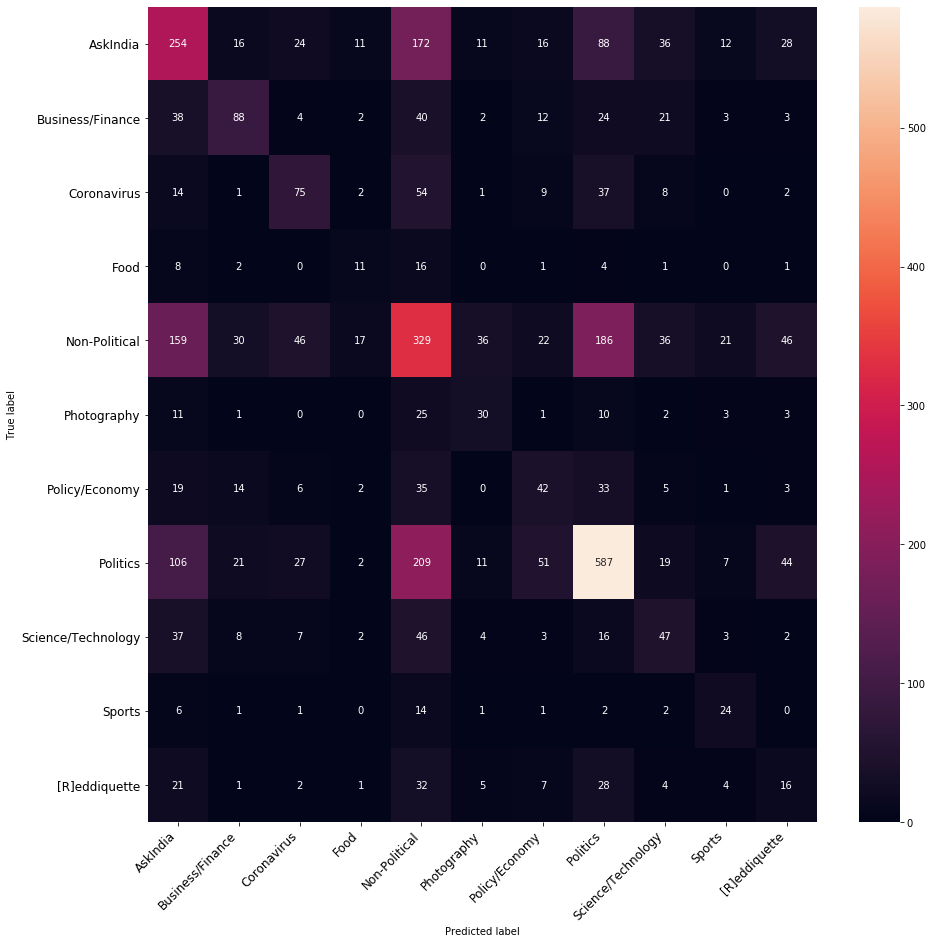

In [33]:
evaluate_model(lsvc, X_test_selected, y_test, target_names=le.classes_)

### 4. Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
# default params
dt = RandomForestClassifier()
dt.fit(X_selected, y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy test: 0.50 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.52      0.69      0.59       668
  Business/Finance       0.76      0.37      0.50       237
       Coronavirus       0.63      0.49      0.55       203
              Food       0.80      0.18      0.30        44
     Non-Political       0.44      0.50      0.47       928
       Photography       0.68      0.20      0.31        86
    Policy/Economy       0.66      0.14      0.24       160
          Politics       0.62      0.79      0.69      1084
Science/Technology       0.52      0.10      0.16       175
            Sports       0.82      0.27      0.41        52
     [R]eddiquette       0.62      0.04      0.08       121

          accuracy                           0.55      3758
         macro avg       0.64      0.34      0.39      3758
      weighted avg       0.57      0.55      0.52      3758

Test confusion matrix: 


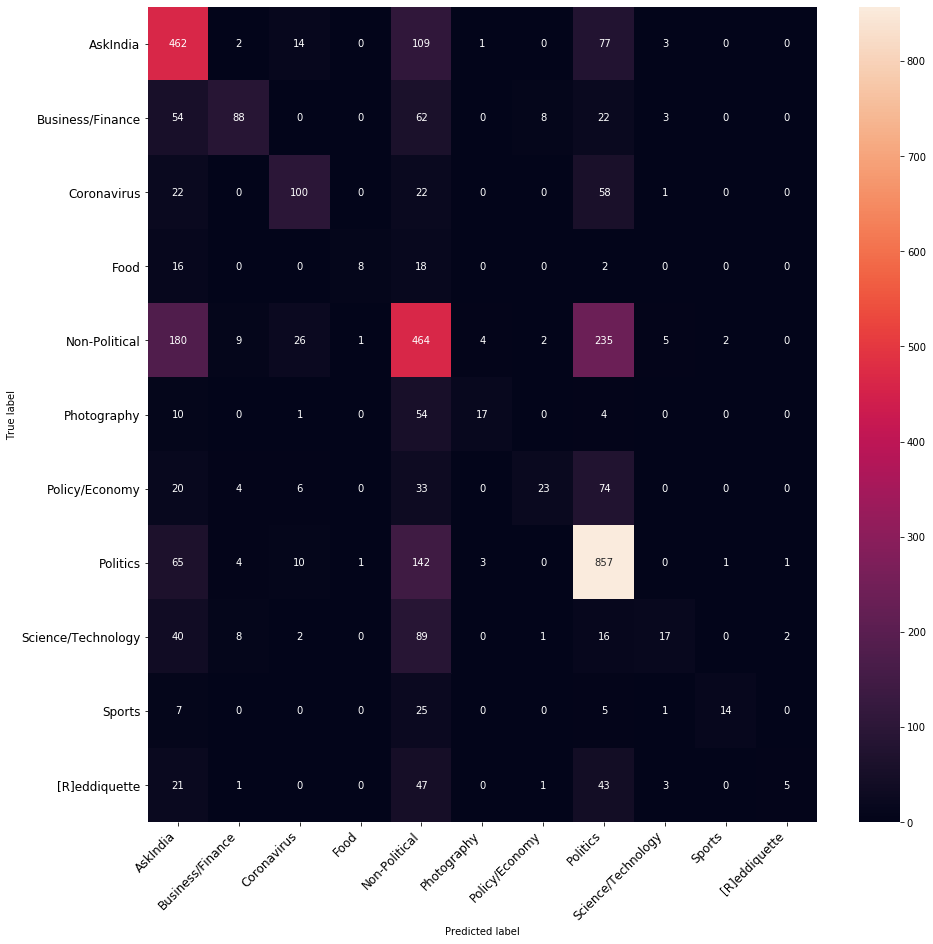

In [38]:
evaluate_model(dt, X_test_selected, y_test, target_names=le.classes_)

###  5. Gradient Boost Classifier 

In [39]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [42]:
gbc = GradientBoostingClassifier()
gbc.fit(X_selected, y_train)

Accuracy test: 0.58 (+/- 0.00)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.59      0.58      0.59      1852
  Business/Finance       0.53      0.19      0.28       264
       Coronavirus       0.62      0.67      0.65       572
              Food       0.52      0.28      0.36       104
     Non-Political       0.40      0.59      0.48      2159
       Photography       0.66      0.39      0.49       204
    Policy/Economy       0.61      0.30      0.40       415
          Politics       0.74      0.74      0.74      3104
Science/Technology       0.52      0.14      0.22       324
            Sports       0.70      0.47      0.56       135
     [R]eddiquette       0.35      0.09      0.14       327

          accuracy                           0.58      9460
         macro avg       0.57      0.40      0.45      9460
      weighted avg       0.59      0.58      0.56      9460

Test confusion matrix: 


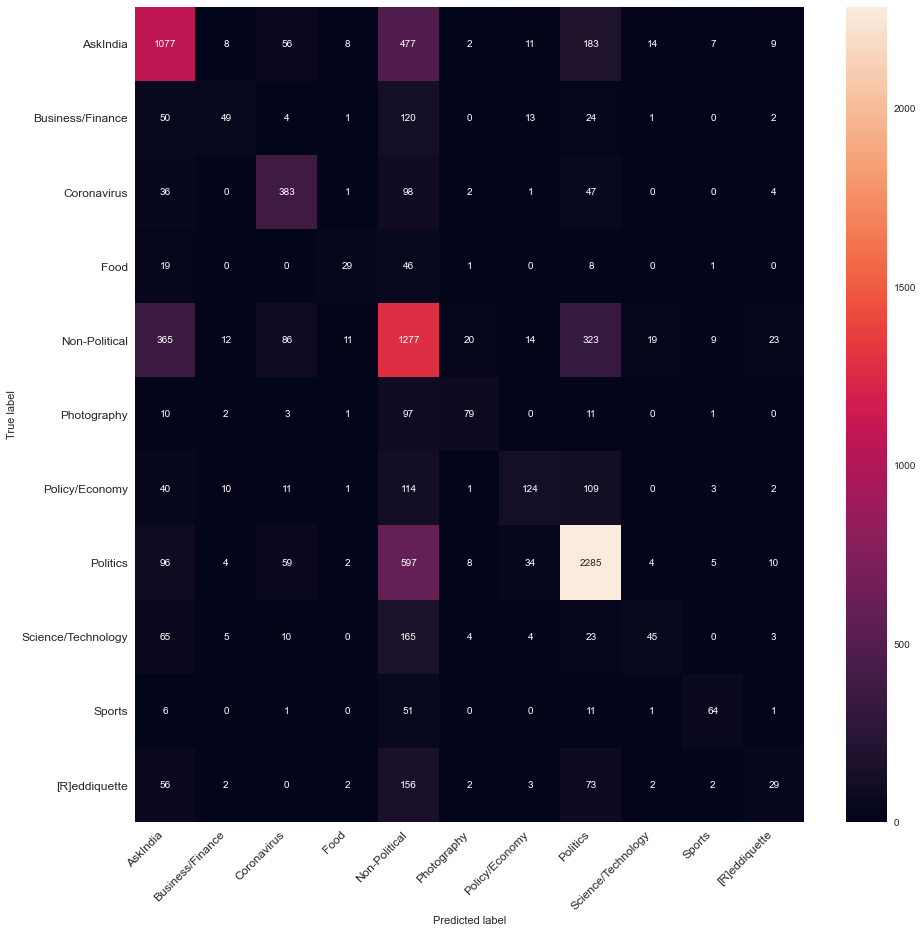

In [184]:
evaluate_model(gbc, X_test_selected, y_test)

### 5. Text Classification using Flair 

- Classification using flair embeddings 

- Text was converted into fasttest format

- Due to computational resources it was trained on Google Colab colab.research.google.com

- A comprehensive Classification report is attached below

- Complete training logs including trained model can be obtained from here:

    - https://drive.google.com/file/d/1vc1f0em0pBZ4mFN7xYYOuuR5OHoi7Ioe/view?usp=sharing

## ![flair classification report](assets/flair-classification-report.jpg)

#### Click here to see the notebook: https://colab.research.google.com/drive/1fMgUPeOvAcUe9zJlZdTEJgqmf9xKBYCU

## Classification using customm DL models

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt

# import our models from custom_models module visit the module in rfd subdir to see the architectures 
from rfd.custom_models import BiLSTM, CNN, BiLSTM_Attn
#embedding loader
from rfd.load_embedding import load_embedding


Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')

In [3]:
df = pd.read_csv("dataframes/df_processed.csv", usecols=['text', 'link_flair_text'])

In [4]:
le =  LabelEncoder().fit(df.link_flair_text)
df['label'] = le.transform(df.link_flair_text)

In [5]:
# #  save the labelencoder object
# with open("LabelEncoder.pkl", "wb") as fp:
#     pickle.dump(le, fp)

#### Parameters

In [6]:
BATCH_SIZE=128
EPOCHS=20
max_len=356
vocabulary_size = 50000
es = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=3) # ES will be somewhat same for all models

In [7]:
### Create sequence
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=max_len)

In [8]:
with open("tokenizer.pkl", "wb") as fp:
    pickle.dump(tokenizer, fp)

In [9]:
X_train, X_test, y_train, y_test  = train_test_split(
    data, 
    to_categorical(df['label'], num_classes=11),
    test_size=0.1
)

In [10]:
print(f'training data :{X_train.shape, y_train.shape}\ntesting data: {X_test.shape, y_test.shape}')

training data :((90181, 200), (90181, 11))
testing data: ((10021, 200), (10021, 11))


### BiLSTM Model (with trainable embeddings)

In [12]:
## Checkpoints
lstm_mcp = ModelCheckpoint('trained_models/lstm.h5', monitor="val_accuracy", save_best_only=True)

In [13]:
# create model
bilstm = BiLSTM(
    vocabulary_size=vocabulary_size,
    max_len=max_len,
    n_classes=11
    )

In [14]:
# train model
bilstm.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    callbacks=[es, lstm_mcp],
    validation_data=(X_test, y_test)
)

Train on 90181 samples, validate on 10021 samples
Epoch 1/20
90181/90181 [==============================] - 71s 787us/step - loss: 1.4389 - accuracy: 0.5211 - val_loss: 1.1751 - val_accuracy: 0.6100
Epoch 2/20
90181/90181 [==============================] - 65s 718us/step - loss: 1.0689 - accuracy: 0.6422 - val_loss: 1.1287 - val_accuracy: 0.6212
Epoch 3/20
90181/90181 [==============================] - 64s 712us/step - loss: 0.8954 - accuracy: 0.7002 - val_loss: 1.1705 - val_accuracy: 0.6145
Epoch 4/20
90181/90181 [==============================] - 65s 716us/step - loss: 0.7446 - accuracy: 0.7534 - val_loss: 1.2499 - val_accuracy: 0.6037
Epoch 5/20
90181/90181 [==============================] - 61s 675us/step - loss: 0.6166 - accuracy: 0.7979 - val_loss: 1.3677 - val_accuracy: 0.5941


In [15]:
model = load_model('trained_models/lstm.h5')

In [16]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

10021/10021 [==============================] - 2s 151us/step


[1.1287452404328466, 0.6211954951286316]

### BiLSTM with pretrained embeddings (Glove Vector)

#### Loading Embeddings

In [25]:
embeddings_index = dict()
f = open('./embeddings/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [26]:
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [27]:
# If trainable(embedding layer) is false because we are using pretrained embedding
bilstm_glove =  BiLSTM(
    vocabulary_size=vocabulary_size,
    max_len=max_len,
    n_classes=11,
    trainable=False,
    embedding_matrix=embedding_matrix
)

In [74]:
# bilstm_glove.summary()

In [28]:
lstm_glove_mcp = ModelCheckpoint('trained_models/lstm-glove.h5', monitor="val_accuracy", save_best_only=True)

In [29]:
bilstm_glove.fit(
    x=X_train, 
    y=y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[lstm_glove_mcp, es], 
    validation_data=(X_test, y_test)
)

Train on 90181 samples, validate on 10021 samples
Epoch 1/20
90181/90181 [==============================] - 61s 675us/step - loss: 1.4457 - accuracy: 0.5066 - val_loss: 1.2773 - val_accuracy: 0.5585
Epoch 2/20
90181/90181 [==============================] - 61s 675us/step - loss: 1.2762 - accuracy: 0.5564 - val_loss: 1.2100 - val_accuracy: 0.5775
Epoch 3/20
90181/90181 [==============================] - 61s 679us/step - loss: 1.2341 - accuracy: 0.5712 - val_loss: 1.1864 - val_accuracy: 0.5850
Epoch 4/20
90181/90181 [==============================] - 57s 631us/step - loss: 1.2075 - accuracy: 0.5782 - val_loss: 1.1744 - val_accuracy: 0.5891
Epoch 5/20
90181/90181 [==============================] - 56s 625us/step - loss: 1.1917 - accuracy: 0.5835 - val_loss: 1.1751 - val_accuracy: 0.5909
Epoch 6/20
90181/90181 [==============================] - 56s 623us/step - loss: 1.1717 - accuracy: 0.5886 - val_loss: 1.1661 - val_accuracy: 0.5897
Epoch 7/20
90181/90181 [==============================] 

In [34]:
model = load_model('trained_models/lstm-glove.h5')

In [35]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

10021/10021 [==============================] - 1s 146us/step


[1.150709758546226, 0.603931725025177]

In [73]:
model.predict(X_test[15].reshape(1, 200))

array([[0.15384233, 0.07712708, 0.09118622, 0.01021124, 0.35761017,
        0.00522425, 0.0283259 , 0.04516279, 0.08160911, 0.13420531,
        0.01549559]], dtype=float32)

In [78]:
model.predict(X_test[15].reshape(1, 200)).argsort()[0]

array([ 5,  3, 10,  6,  7,  1,  8,  2,  9,  0,  4], dtype=int64)

In [98]:
p = model.predict(X_test[39].reshape(1, 200)).argsort()[0][-3:]

In [99]:
print(le.classes_[p[0]], le.classes_[p[1]], le.classes_[p[2]])

Politics AskIndia Non-Political


In [100]:
le.classes_[np.argmax(y_train[39])]

'Non-Political'

### Classification using Word Level CNN 

In [101]:
# create model form custom import function see custom_models files in rfd package or run CNN?
cnn = CNN(
    vocabulary_size=vocabulary_size,
    max_len=max_len
)

In [103]:
mcp_cnn = ModelCheckpoint('trained_models/cnn.h5', monitor="val_accuracy", save_best_only=True)

In [105]:
hist = cnn.fit(
    x=X_train, 
    y=y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[mcp_cnn, es], 
    validation_data=(X_test, y_test)
)

Train on 90181 samples, validate on 10021 samples
Epoch 1/20
90181/90181 [==============================] - 15s 161us/step - loss: 1.3387 - accuracy: 0.5551 - val_loss: 1.1009 - val_accuracy: 0.6272
Epoch 2/20
90181/90181 [==============================] - 13s 142us/step - loss: 0.9466 - accuracy: 0.6778 - val_loss: 1.0756 - val_accuracy: 0.6365
Epoch 3/20
90181/90181 [==============================] - 13s 142us/step - loss: 0.6793 - accuracy: 0.7728 - val_loss: 1.1637 - val_accuracy: 0.6259
Epoch 4/20
90181/90181 [==============================] - 13s 142us/step - loss: 0.4243 - accuracy: 0.8647 - val_loss: 1.3275 - val_accuracy: 0.6103
Epoch 5/20
90181/90181 [==============================] - 13s 144us/step - loss: 0.2317 - accuracy: 0.9343 - val_loss: 1.5412 - val_accuracy: 0.5962


In [106]:
model = load_model("trained_models/cnn.h5")

In [107]:
model.evaluate(X_test, y_test)

10021/10021 [==============================] - 2s 151us/step


[1.0756429027754466, 0.6364634037017822]

### Get the top three predictions

In [144]:
p = model.predict(X_test[53].reshape(1, 200)).argsort()[0][-3:]

In [145]:
print(le.classes_[p[2]], le.classes_[p[1]], le.classes_[p[0]])

Coronavirus Politics Non-Political


In [146]:
le.classes_[np.argmax(y_train[53])]

'Politics'

###  Classification using attention based LSTM

In [158]:
bisltm_attn = BiLSTM_Attn(
    vocabulary_size=vocabulary_size,
    max_len=max_len
)

In [159]:
mcp_attn = ModelCheckpoint('trained_models/attention-lstm.h5', monitor="val_accuracy", save_best_only=True,  save_weights_only=True)

In [160]:
hist = bisltm_attn.fit(
    x=X_train, 
    y=y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[mcp_attn, es], 
    validation_data=(X_test, y_test)
)

Train on 90181 samples, validate on 10021 samples
Epoch 1/20
90181/90181 [==============================] - 113s 1ms/step - loss: 1.4891 - accuracy: 0.5044 - val_loss: 1.2432 - val_accuracy: 0.5912
Epoch 2/20
90181/90181 [==============================] - 112s 1ms/step - loss: 1.0922 - accuracy: 0.6376 - val_loss: 1.1514 - val_accuracy: 0.6166
Epoch 3/20
90181/90181 [==============================] - 114s 1ms/step - loss: 0.8660 - accuracy: 0.7150 - val_loss: 1.1811 - val_accuracy: 0.6133
Epoch 4/20
90181/90181 [==============================] - 114s 1ms/step - loss: 0.6615 - accuracy: 0.7869 - val_loss: 1.3145 - val_accuracy: 0.5948
Epoch 5/20
90181/90181 [==============================] - 109s 1ms/step - loss: 0.4881 - accuracy: 0.8454 - val_loss: 1.4465 - val_accuracy: 0.5838


## 9. Multimodal Architecture
- A reddit submisison has more than just text data (ie: num_comments, upvotes, downvotes etc) and in EDA plots suggest correlation between flair and these statistical features.
- Apart from the text we have some numerical and pos features of test data related to the submission.
- To process text and numerical features(listed above) we need an architecture which takes care of both numerical as well textual features of the submission.
- **LSTM for text data** and **DNN for numerical features**

## Pre-trained Models

### Ref: https://github.com/ThilinaRajapakse/simpletransformers

### 10. Classification uisng DistilBERT

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
tqdm.pandas()

In [2]:
# read the csv file
df = pd.read_csv("df.csv", usecols=['text', 'link_flair_text'])

In [3]:
# encode the categorical flair into numerical labels
le = LabelEncoder().fit(df.link_flair_text)
df['label'] = le.transform(df.link_flair_text)

In [4]:
# split the dataset into train/test set
train, test = train_test_split(df[['text', 'label']], test_size=0.1) 

In [5]:
print(train.shape, test.shape)

(90334, 2) (10038, 2)


In [6]:
train.head()

,text,label
92222,No economic task force for COVID-19 yet Modi'...,2
13012,"Jumla cycle. In the last one month alone, Modi...",7
47921,Remembering Bharatendu Harishchandra on Hindi ...,4
28102,This was on my Uber cab's rear view mirror. It...,4
86082,The hearts of Muslims all over the world are g...,7


In [19]:
from simpletransformers.classification import ClassificationModel
from args import args

#### Fine-tuning the DistillBERT

In [22]:
from multiprocessing import cpu_count

In [23]:
args = {
    "output_dir": "outputs/",
    "cache_dir": "cache/",
    "best_model_dir": "outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 128,
    "train_batch_size": 128,
    "eval_batch_size": 128,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 1,
    "weight_decay": 0,
    "learning_rate": 1e-4,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,

    "logging_steps": 50,
    "evaluate_during_training": False,
    "evaluate_during_training_steps": 2000,
    "evaluate_during_training_verbose": False,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": True,
    "no_cache": False,
    "save_model_every_epoch": True,
    "tensorboard_dir": None,

    "overwrite_output_dir": True,
    "reprocess_input_data": True,

    "process_count": cpu_count() ,
    "n_gpu": 1,
    "silent": False,
    "use_multiprocessing": True,

    "wandb_project": None,
    "wandb_kwargs": {},

    "use_early_stopping": True,
    "early_stopping_patience": 2,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,

    "manual_seed": 0,
    "encoding": None,
    "config": {},
}

In [24]:
# default args
model = ClassificationModel('distilbert', 'distilbert-base-cased', num_labels=11,  args=args)

In [25]:
model.train_model(train_df=train)

Current iteration:   0%|          | 0/706 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 6.00 GiB total capacity; 4.51 GiB already allocated; 42.13 MiB free; 4.54 GiB reserved in total by PyTorch)

## OOPs cuda ran out of memory as it was expected, Tho I have folllowing configuration
- 9th Gen Core i7
- 16GB RAM
- Nvidia RTX2060 6GB

but it was not sufficient so I have trained(finetuned these models on colab), notebook can be found in current directoary name pretrained_models.ipynb

### 11. XLNet 

### 12. Multimodal Architecture for Text Classification (DNN+LSTM)

### Summary 